In [ ]:
!pip install -U statsmodels

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.1 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.dates as dates
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
import pmdarima as pm

In [ ]:
from statsmodels.tools.eval_measures import mse, rmse, meanabs
from statsmodels.stats.stattools import durbin_watson
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller

In [ ]:
def rmse(y, x):
  return np.sqrt(mean_squared_error(y,x))

In [ ]:
def rmse2(result, Ntest, test, is_logged):
  forecast = result.forecast(Ntest)
  if is_logged:
    forecast = np.exp(forecast)

  t = test.copy()
  y = forecast.copy()

  return np.sqrt(np.mean((t-y)**2))

In [ ]:
hate_crime = pd.read_csv('hate_crime.csv', header=0, encoding='utf-8')

selected_columns = ['incident_id', 'incident_date']
data = hate_crime[selected_columns].copy()

# General Hate Crime
data['incident_dttm'] = pd.to_datetime(data['incident_date'])

In [ ]:
daily_counts = data.groupby(['incident_dttm'])[['incident_id']].count()\
    .rename(columns={'incident_id': 'counts'})\
    .reset_index().set_index('incident_dttm')

In [ ]:
monthly_data = daily_counts.resample(rule='M').sum()

<Axes: xlabel='incident_dttm'>

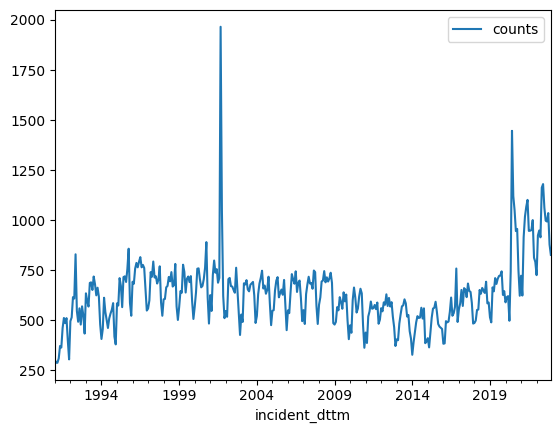

In [ ]:
monthly_data.plot()

In [ ]:
monthly_data.index.freq

<MonthEnd>

In [ ]:
monthly_data['1stdiff'] = monthly_data['counts'].diff()

In [ ]:
monthly_data['logcount'] = np.log(monthly_data['counts'])

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

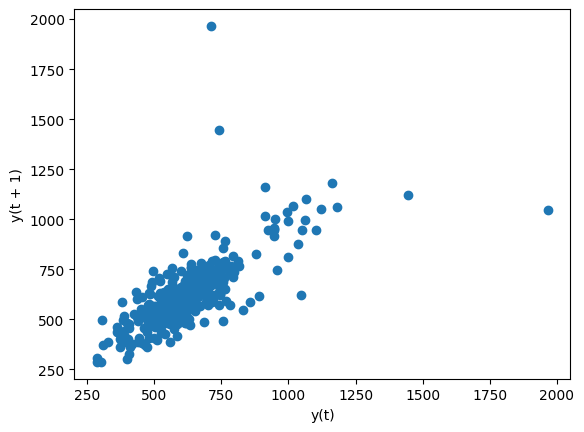

In [ ]:
pd.plotting.lag_plot(monthly_data['counts'])

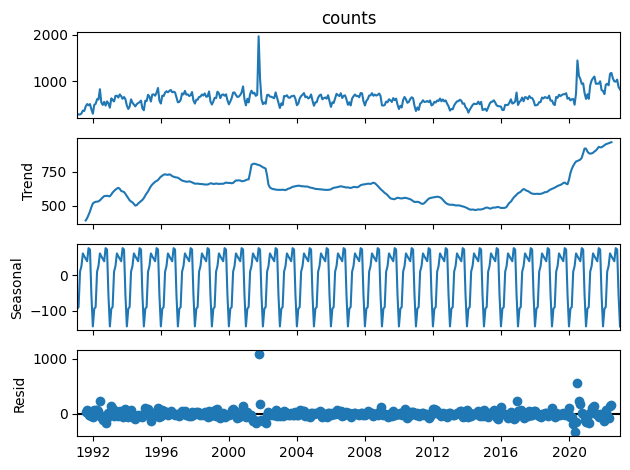

In [ ]:
seasonal_decompose(monthly_data['counts'], model='additive').plot();

In [ ]:
Ntest=12
train = monthly_data.iloc[:-Ntest]
test = monthly_data.iloc[-Ntest:]

In [ ]:
train_idx = monthly_data.index <= train.index[-1]
test_idx = ~train_idx

In [ ]:
## ARIMA Model Assumption: Stationarity

In [ ]:
# Augmented Dickey fuller test

In [ ]:
dftest = adfuller(monthly_data['counts'])
dfout = pd.Series(dftest[0:4], index=['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations'])

In [ ]:
for key,val in dftest[4].items():
  dfout[f'critical value({key})'] = val

In [ ]:
dfout

,0
ADF Test Statistic,-1.000560
p-value,0.753060
# Lags Used,12.000000
# Observations,371.000000
critical value(1%),-3.448100
critical value(5%),-2.869362
critical value(10%),-2.570937


In [ ]:

if dftest[1] <= 0.05:
  print("Reject the null hypothesis")
  print("Data is stationary")
else:
  print("Weak evidence against the null hypothesis")
  print("Fail to reject the null hypothesis")
  print("Data is non-stationary")

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data is non-stationary


In [ ]:
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs

In [ ]:
adf_test = ADFTest(alpha=.05)
p_val, should_diff = adf_test.should_diff(daily_counts['counts'])

In [ ]:
should_diff

False

In [ ]:
n_adf = ndiffs(monthly_data['counts'], test='adf')

In [ ]:
n_kpss = ndiffs(monthly_data['counts'], test='kpss')

In [ ]:
n_pp = ndiffs(monthly_data['counts'], test='pp')

In [ ]:
n_kpss

1

In [ ]:
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [ ]:
## Choosing Arima hyperparameters d, p and q

In [ ]:
# ACF: Choosing the MA component(q)

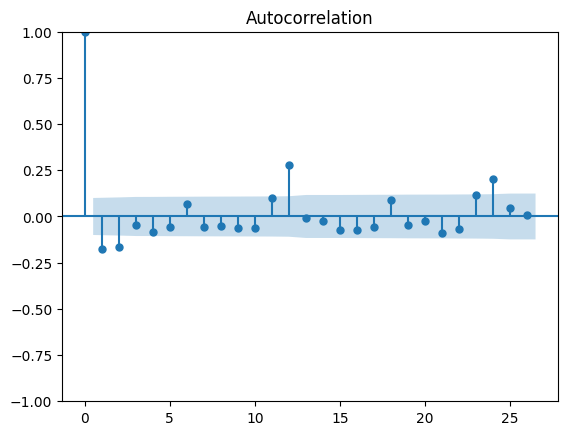

In [ ]:
plot_acf(monthly_data['1stdiff'][1:]);

In [ ]:
# PACF - choosing AR component(p)

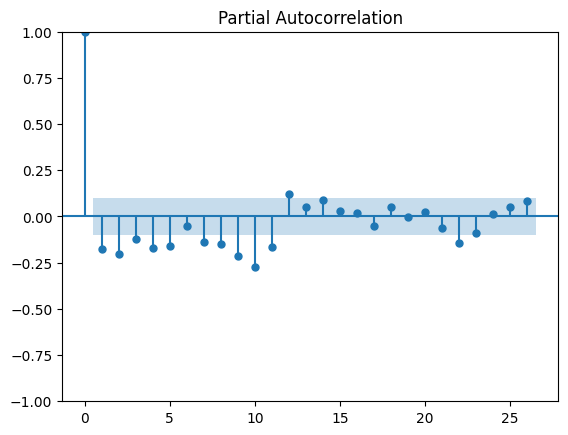

In [ ]:
plot_pacf(monthly_data['1stdiff'][1:]);

In [ ]:
# Suggestion based on ACF/ PACF (5,1,2)

In [ ]:
arima_512 = ARIMA(train['counts'], order=(5,1,2))
result_512 = arima_512.fit()
train_pred_512 = result_512.predict(start=train.index[1], end=train.index[-1])
train_fitted_512 = result_512.fittedvalues
forecast_512 = result_512.get_forecast(Ntest).predicted_mean
confint_512 = result_512.get_forecast(Ntest).conf_int()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
## Check Accuracy
np.sqrt(mean_squared_error(test['counts'], forecast_512))

144.8992355939956

In [ ]:
mean_absolute_percentage_error(test['counts'], forecast_512)

0.11553925152999278

In [ ]:
lower, upper = confint_512['lower counts'], confint_512['upper counts']

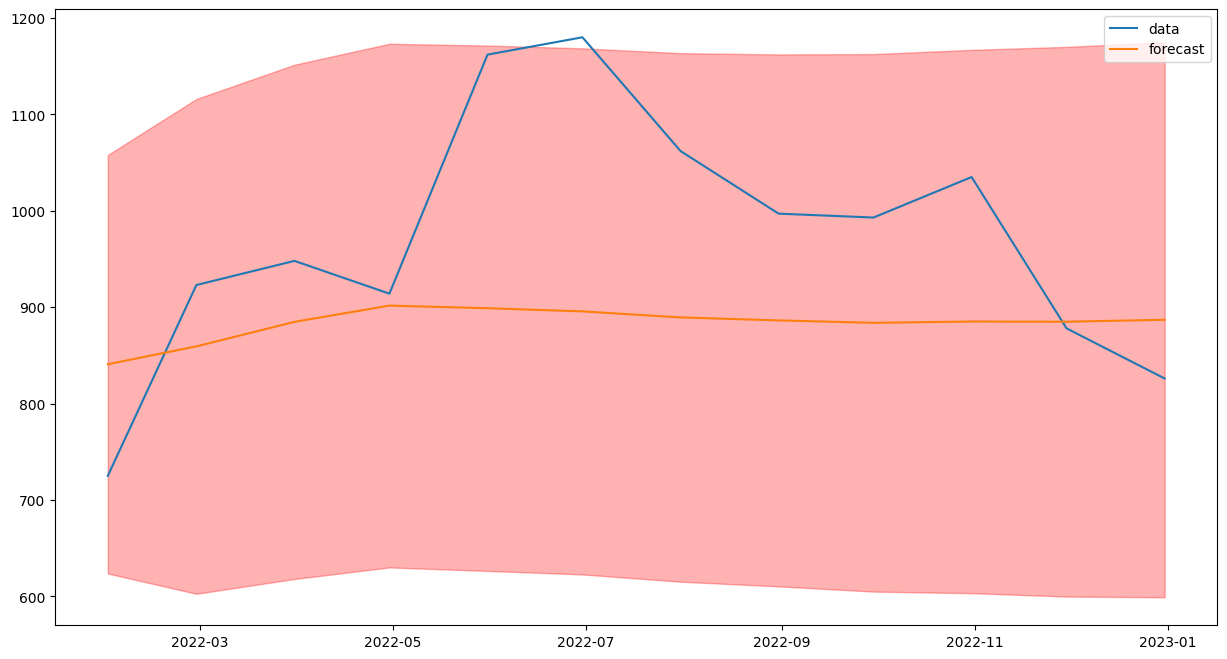

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(test.index, test['counts'], label='data')
ax.plot(test.index, forecast_512, label='forecast')
ax.fill_between(test.index, lower, upper, color='red', alpha=.3)
ax.legend()


In [ ]:
### Method used by Grid Search

In [ ]:
def choose_model(train, test, d, order, is_log=False):
  arima = ARIMA(train, order=order)
  result = arima.fit()
  train_preds = result.predict(start=train.index[d], end=train.index[-1])
  train_fitted = result.fittedvalues
  forecast = result.get_forecast(Ntest).predicted_mean

  if is_log:
    forecast = np.exp(forecast)

  aic_val = result.aic
  bic_val = result.bic

  rmse = np.sqrt(mean_squared_error(test, forecast))
  mape = mean_absolute_percentage_error(test, forecast)
  r_squared = r2_score(test, forecast)

  return rmse, mape, r_squared, aic_val, bic_val

In [ ]:
def plot_fit_and_forecast(result, d, col='counts', is_log=False):
  fig, ax = plt.subplots(figsize=(15,8))
  ax.plot(monthly_data['counts'], label='data')


  train_pred = result.predict(start=train.index[d], end=train.index[-1])
  if is_log:
    train_pred = np.exp(train_pred)
  ax.plot(train.index[d:], train_pred, color='green', label='fitted')

  prediction_result = result.get_forecast(Ntest)
  conf_int = prediction_result.conf_int()
  lower, upper = conf_int[f'lower {col}'], conf_int[f'upper {col}']
  forecast = prediction_result.predicted_mean

  if is_log:
    forecast = np.exp(forecast)
    lower = np.exp(lower)
    upper = np.exp(upper)

  ax.plot(test.index, forecast, label='out of sample forecast')
  ax.fill_between(test.index, lower, upper, color='red', alpha=.3)

  ax.legend()


In [ ]:
df = pd.DataFrame(columns=['p', 'q', 'd', 'rmse', 'mape', 'r_squared', 'aic', 'bic'])

In [ ]:
for p in range(1,6,1):
  for q in range(1,9,1):
    for d in range(2):
      rmse, mape, r_squared, aic, bic = choose_model(train['logcount'], test['counts'], d, (p,d,q), is_log=True)
      row = [p, q, d, rmse, mape, r_squared, aic, bic]
      df.loc[len(df)] = row

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

In [ ]:
df.sort_values(by='aic', ascending=True).head(1)

,p,q,d,rmse,mape,r_squared,aic,bic
41,3.0,5.0,1.0,98.16716,0.07851,0.391246,-415.557671,-380.311852


In [ ]:
df.sort_values(by='bic', ascending=True).head(1)

,p,q,d,rmse,mape,r_squared,aic,bic
41,3.0,5.0,1.0,98.16716,0.07851,0.391246,-415.557671,-380.311852


In [ ]:
model_315 = ARIMA(train['logcount'], order=(3,1,5))
result_315 = model_315.fit()
forecast_315 = result_315.get_forecast(Ntest).predicted_mean
confint_315 = np.exp(result_315.get_forecast(Ntest).conf_int())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
result_315.aic

-415.55767076385024

In [ ]:
result_315.bic

-380.3118522003833

In [ ]:
np.sqrt(mean_squared_error(test['counts'], np.exp(forecast_315)))

98.16715958473822

In [ ]:
mean_absolute_percentage_error(test['counts'], np.exp(forecast_315))

0.07851028684650375

In [ ]:
r2_score(test['counts'], np.exp(forecast_315))

0.3912460125985521

In [ ]:
lower, upper = confint_315['lower logcount'], confint_315['upper logcount']

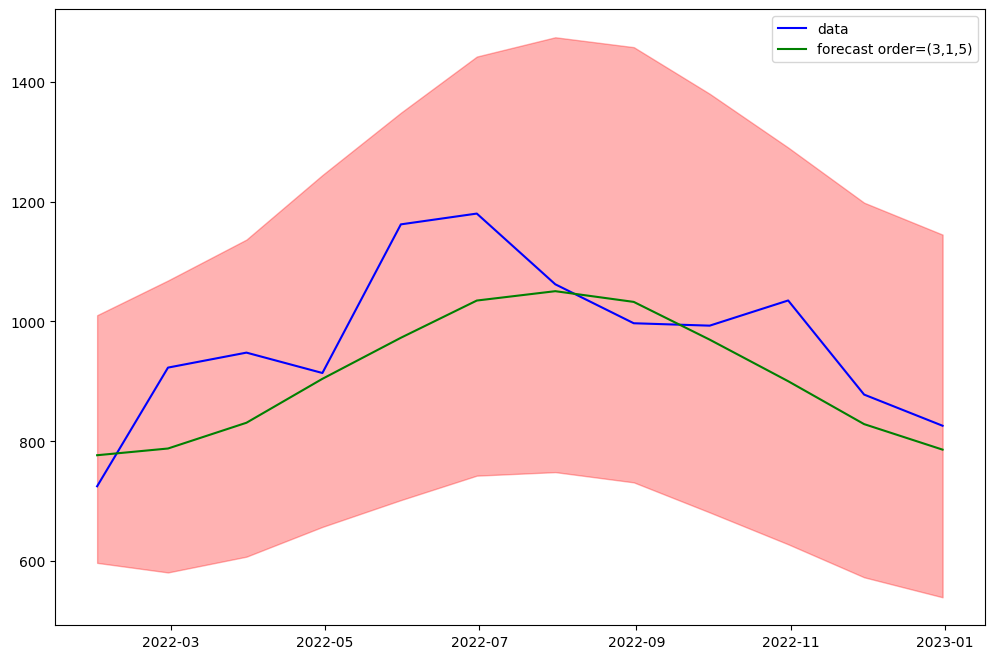

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(test.index, test['counts'], label='data', color='blue')
ax.plot(test.index, np.exp(forecast_315), label='forecast order=(3,1,5)', color='green')
ax.fill_between(test.index, lower, upper, color='red', alpha=.3)
ax.legend()

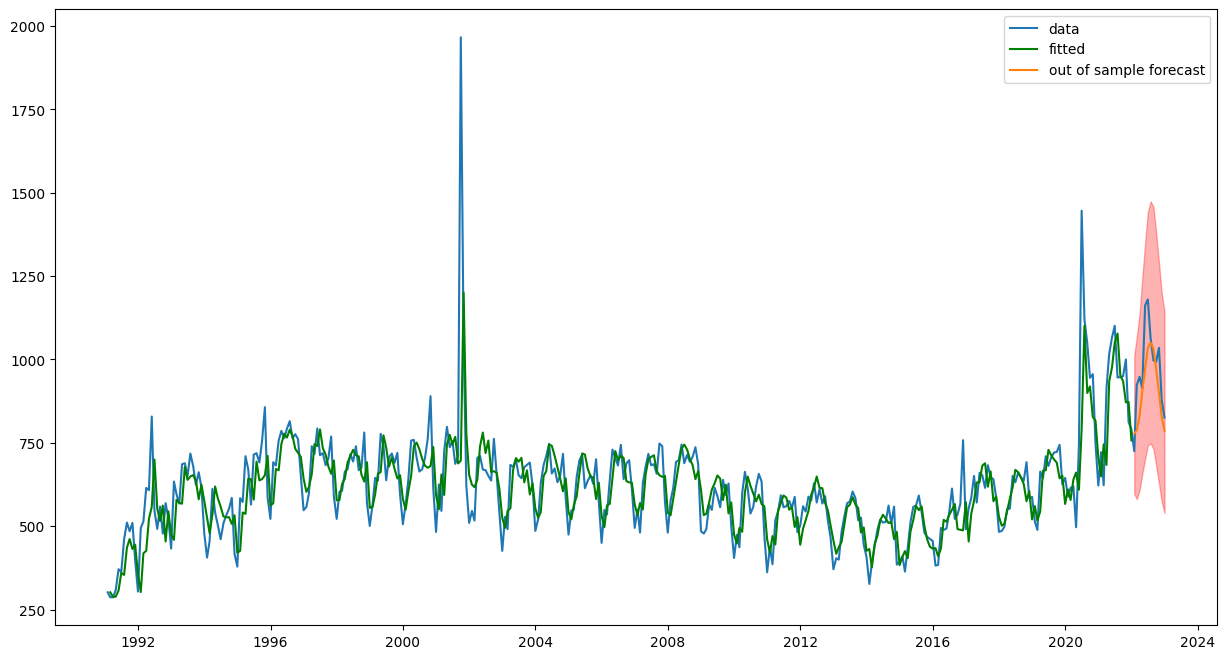

In [ ]:
plot_fit_and_forecast(result_315, 1, col='logcount', is_log=True)

In [ ]:
## PMDARIMA - with Seasonality

In [ ]:
# Had to add d=1 because it was not differencing, even when using

In [ ]:
model = pm.auto_arima(train['counts'], trace=True, d=1, max_q=8, max_p=8, stepwise=False, error_action='ignore', suppress_warnings=True, seasonal=False)
# out of sample predictions
test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

# in sample predictions


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4637.110, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4617.437, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4569.619, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4564.085, Time=0.24 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4563.335, Time=0.36 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=4565.324, Time=0.47 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4627.070, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4563.236, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4562.542, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4564.453, Time=0.30 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4565.258, Time=0.52 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4613.487, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4562.206, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4556.682, Time=0.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4563.411, Time=0.52 sec
 ARIMA(3,1

In [ ]:
train_pred = model.predict_in_sample(start=1, end=-1)

In [ ]:
forecast, conf_int = model.predict(n_periods=Ntest, return_conf_int=True)

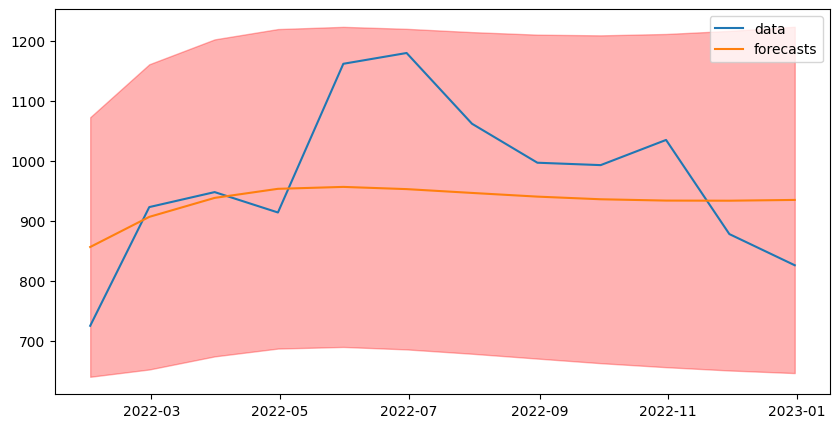

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(test.index, test['counts'], label='data')
ax.plot(test.index, forecast, label='forecasts')
ax.fill_between(test.index, conf_int[:, 0], conf_int[:,1], color='red', alpha=.3)
ax.legend()

In [ ]:
params = model.get_params()

In [ ]:
params

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (2, 1, 2),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [ ]:
d = params['order'][1]

In [ ]:
d

1

In [ ]:
np.sqrt(mean_squared_error(test_pred, test['counts']))

114.68980020264195

In [ ]:
mean_absolute_percentage_error(test_pred, test['counts'])

0.10027799557545854

In [ ]:
# Differencing = 0

In [ ]:
model2 = pm.auto_arima(train['counts'], trace=True, max_q=8, max_p=8, stepwise=False, error_action='ignore', suppress_warnings=True, seasonal=False)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5862.412, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5458.232, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5205.643, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=5066.871, Time=0.43 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=4964.118, Time=1.15 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=1.63 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4649.230, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4631.755, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4586.979, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4581.564, Time=0.26 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=4580.797, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4640.275, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4580.628, Time=0.18 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4580.002, Time=0.33 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(3,0,0)(0,0,0)

In [ ]:
train_pred2 = model2.predict_in_sample(start=1, end=-1)

In [ ]:
forecast2, conf_int2 = model2.predict(n_periods=Ntest, return_conf_int=True)

In [ ]:
# See below that the model without differencing is a bad model

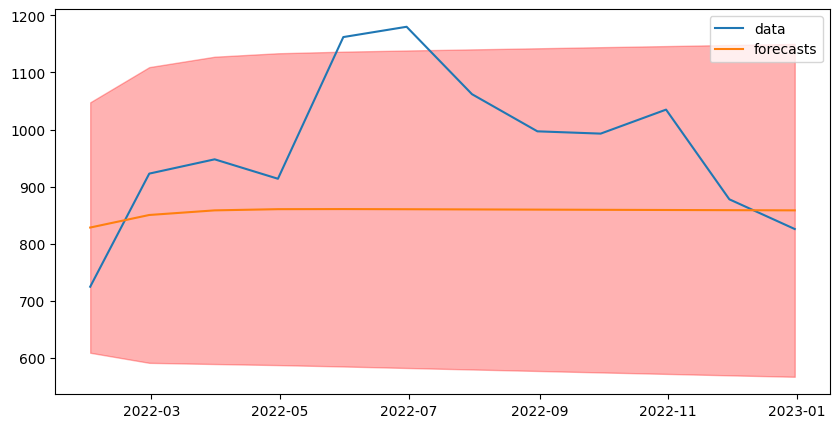

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(test.index, test['counts'], label='data')
ax.plot(test.index, forecast2, label='forecasts')
ax.fill_between(test.index, conf_int2[:,0], conf_int2[:,1], color='red', alpha=.3)
ax.legend()

In [ ]:
# Try SARIMA Model

In [ ]:
seasonal_model = pm.auto_arima(train['counts'],d=1, max_p = 6, max_q=6, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4637.110, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4589.811, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4581.871, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4635.152, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=4617.437, Time=0.09 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=4512.436, Time=0.67 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=4565.156, Time=0.29 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=3.99 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=4569.849, Time=0.90 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=4548.843, Time=0.94 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=2.39 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=4584.872, Time=0.37 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : 

In [ ]:
seasonal_forecast, seasonal_confint = seasonal_model.predict(n_periods=Ntest, return_conf_int=True)

In [ ]:
r2_score(test['counts'], seasonal_forecast)

0.5454542181245075

In [ ]:
np.sqrt(mean_squared_error(test['counts'], seasonal_forecast))

84.8270046155908

In [ ]:
mean_absolute_percentage_error(test['counts'], seasonal_forecast)

0.06264011488692618

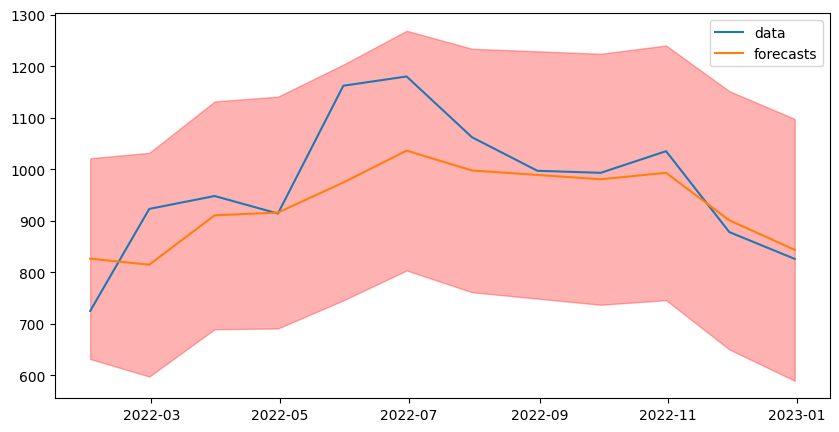

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(test.index, test['counts'], label='data')
ax.plot(test.index, seasonal_forecast, label='forecasts')
ax.fill_between(test.index, seasonal_confint[:,0], seasonal_confint[:,1], color='red', alpha=.3)
ax.legend()

In [ ]:
# Seasonal Model: No Differencing with log transformation

In [ ]:
sarima_log_model = pm.auto_arima(train['logcount'], max_p=8, max_q=4, trace=True, error_action='ignore', suppress_warning=True, seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-455.324, Time=1.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-22.411, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-424.665, Time=0.72 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-307.658, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2439.174, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-395.900, Time=1.49 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-425.834, Time=0.98 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=-431.352, Time=4.51 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=-423.685, Time=3.03 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-335.546, Time=0.33 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=-410.723, Time=2.62 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=-446.909, Time=2.46 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=5.70 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-440.621, Time=1.26 sec
 ARIMA(2,0,1)(1,0,1)[12] 

In [ ]:
seasonal_log_forecast, seasonal_log_conf = sarima_log_model.predict(n_periods=Ntest, return_conf_int=True)

In [ ]:
# Seasonal Model: Differencing and log transformation

In [ ]:
sarima_model_log_diff = pm.auto_arima(train['logcount'], d=1, max_p=8, max_q=4, trace=True, error_action='ignore', suppress_warning=True, seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-298.854, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-384.432, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-362.373, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-300.757, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.640, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-404.501, Time=0.98 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-450.982, Time=2.00 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-452.675, Time=0.78 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-357.188, Time=0.22 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-451.047, Time=4.05 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-371.109, Time=0.83 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=-449.663, Time=1.77 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-430.724, Time=0.47 sec
 ARIMA(2,1,0)(1,0,1)[12]

In [ ]:
sarima_diff_forecast, sarima_diff_confint = sarima_model_log_diff.predict(n_periods=Ntest, return_conf_int=True)

In [ ]:
#Accuracy of the Seasonal Non-Differenced Log counts

In [ ]:
np.sqrt(mean_squared_error(test['counts'], np.exp(seasonal_log_forecast)))

75.60523224691556

In [ ]:
mean_absolute_percentage_error(test['counts'], np.exp(seasonal_log_forecast))

0.05511509483743959

In [ ]:
r2_score(np.exp(seasonal_log_forecast), test['counts'])

0.46169699522401864

In [ ]:
#Accuracy the Seasonal Differenced log model

In [ ]:
np.sqrt(mean_squared_error(test['counts'], np.exp(sarima_diff_forecast)))

72.62109892704406

In [ ]:
mean_absolute_percentage_error(test['counts'], np.exp(sarima_diff_forecast))

0.053494112790323865

In [ ]:
r2_score(test['counts'], np.exp(sarima_diff_forecast))

0.6668536942479533

In [ ]:
# PLot data

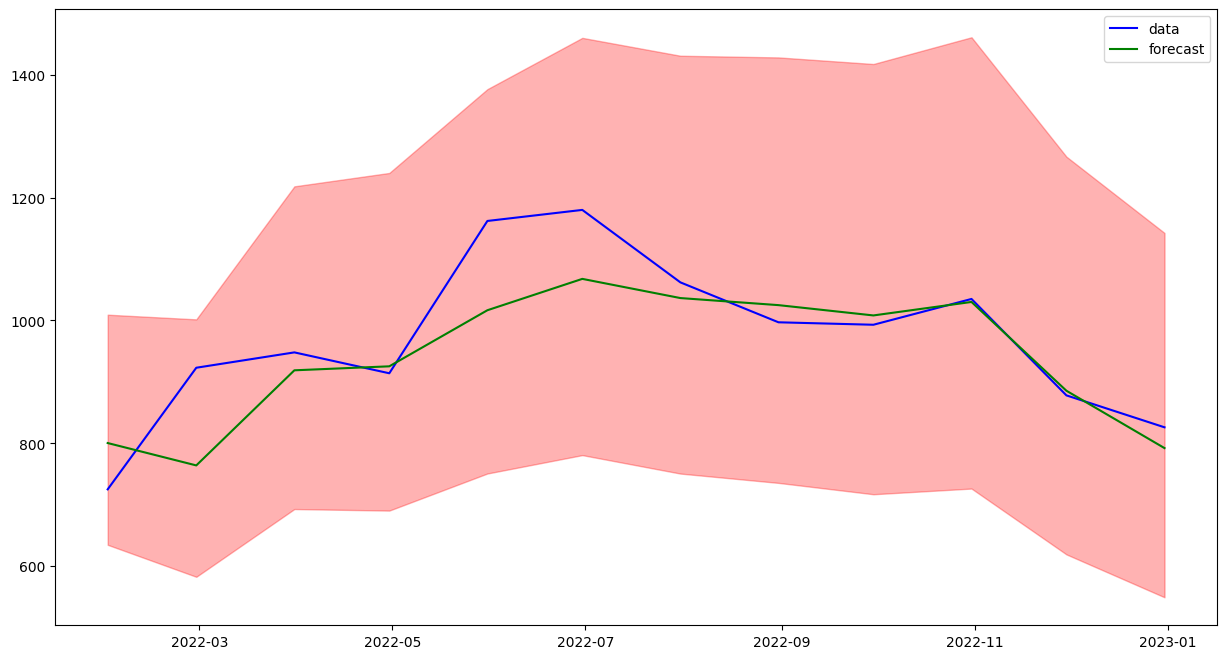

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(test.index, test['counts'], color='blue', label='data')
ax.plot(test.index, np.exp(seasonal_log_forecast), color='green', label='forecast')
ax.fill_between(test.index, np.exp(seasonal_log_conf[:,0]), np.exp(seasonal_log_conf[:,1]), color='red', alpha=.3)
ax.legend()


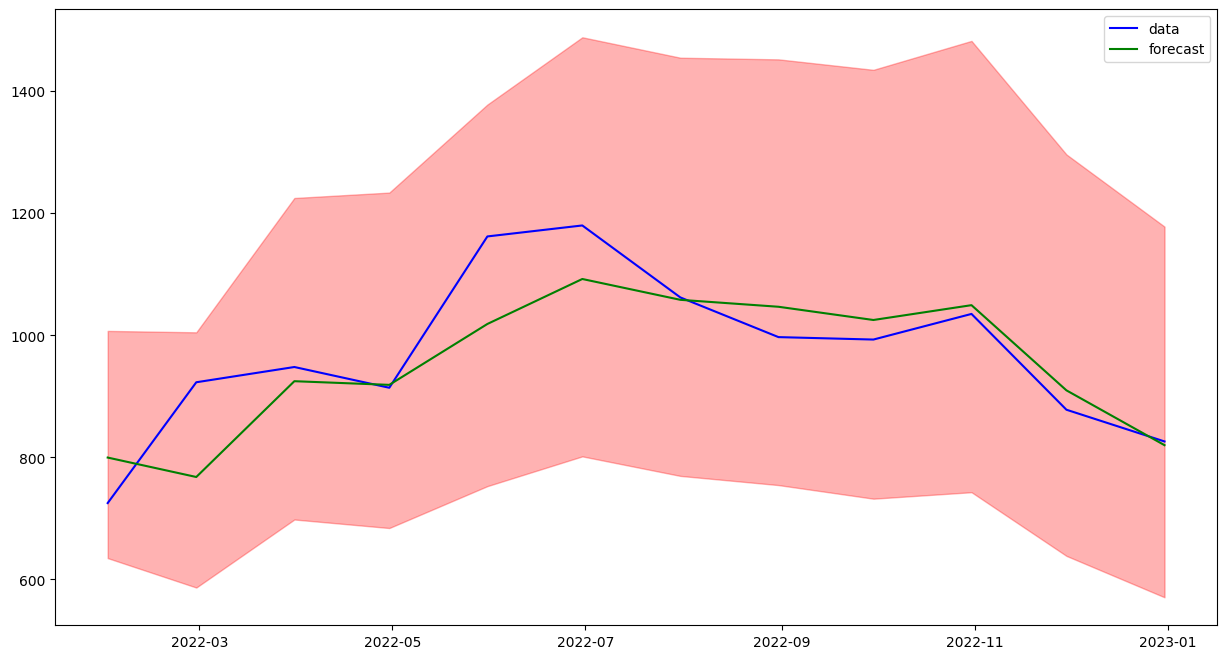

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(test.index, test['counts'], color='blue', label='data')
ax.plot(test.index, np.exp(sarima_diff_forecast), color='green', label='forecast')
ax.fill_between(test.index, np.exp(sarima_diff_confint[:,0]), np.exp(sarima_diff_confint[:,1]), color='red', alpha=.3)
ax.legend()

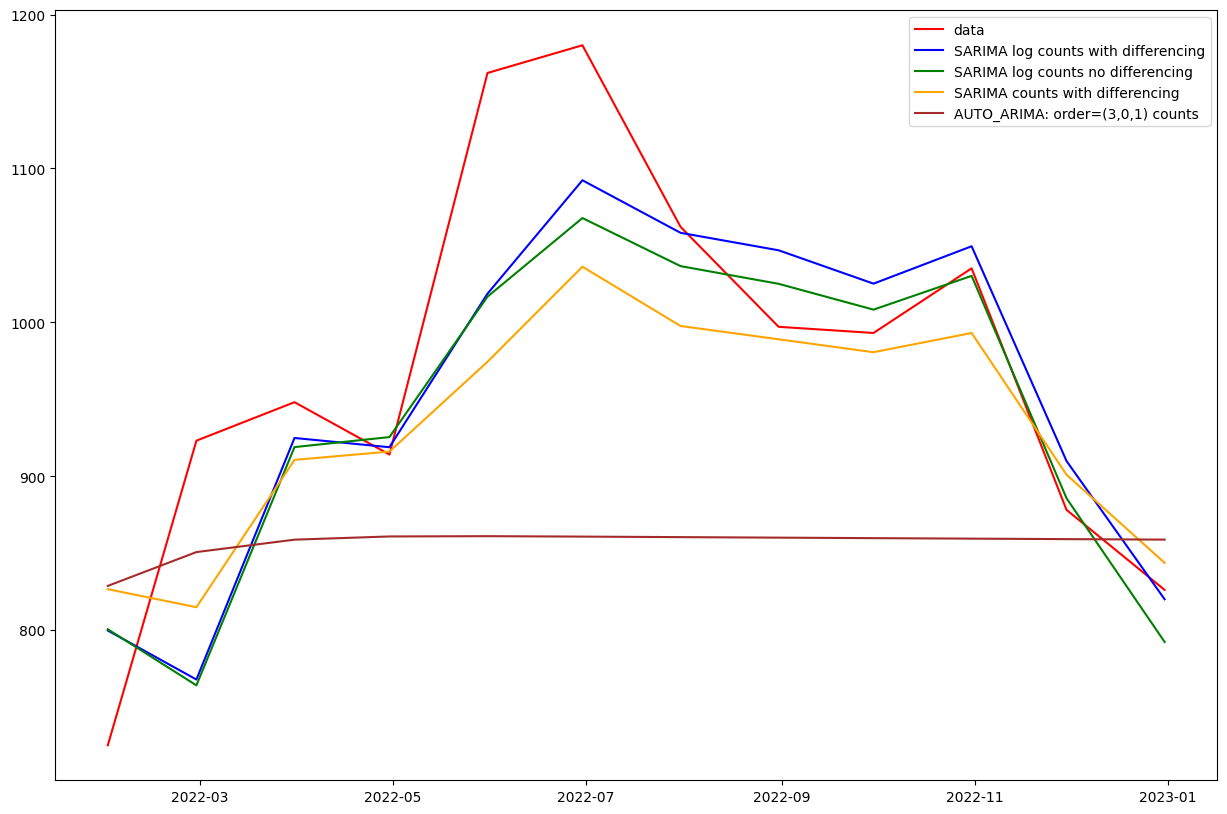

In [105]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(test.index, test['counts'], label='data', color='red')
ax.plot(test.index, np.exp(sarima_diff_forecast), label='SARIMA log counts with differencing', color='blue')
ax.plot(test.index, np.exp(seasonal_log_forecast), label='SARIMA log counts no differencing', color='green')
ax.plot(test.index, seasonal_forecast, label='SARIMA counts with differencing', color='orange')
ax.plot(test.index, forecast2, label='AUTO_ARIMA: order=(3,0,1) counts', color='brown')

ax.legend()

In [ ]:
# Use The Auto-Arima function

In [106]:
residuals = sarima_model_log_diff.resid()

In [107]:
fitted_full = sarima_model_log_diff.fit

In [ ]:
# Model Goodness of fit

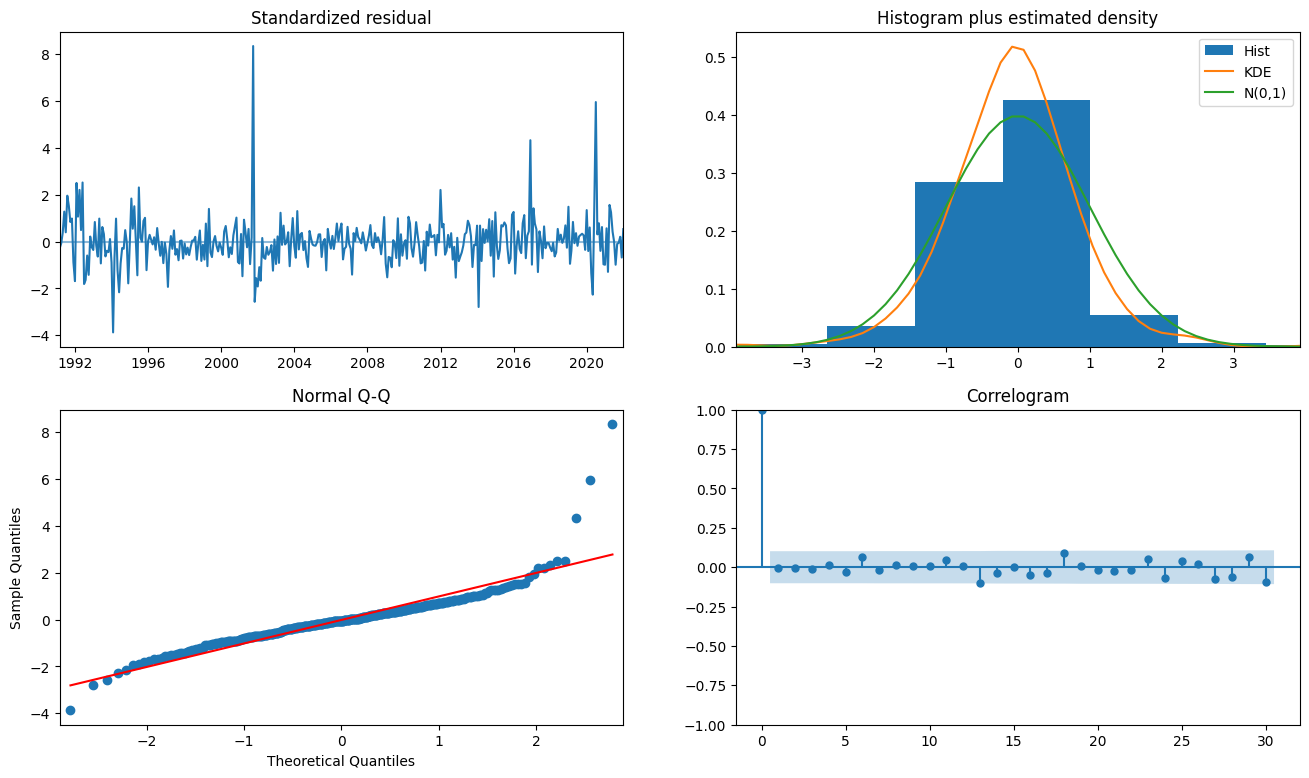

In [108]:
fig = plt.figure(figsize=(16, 9))
fig = sarima_model_log_diff.plot_diagnostics(fig=fig, lags=30)

In [109]:
from scipy.stats import mstats

In [110]:
z, p_val = mstats.normaltest(residuals)

In [111]:
p_val

3.079622303517602e-173

In [112]:
if p_val < .05:
  print("We reject the null hypothesis. Model Assumptions are violated: Residuals are not normally distributed")

We reject the null hypothesis. Model Assumptions are violated: Residuals are not normally distributed


In [ ]:
# Durbin-Watson Test: Searching for Evidence of Serial Correlation of Residuals
# main assumptions is that there is no correlation between consecutive residuals

In [ ]:
# H0 (null hypothesis): There is no correlation among the residuals
# H1 (Alterative hypothesis): The residuals are autocorrelated
# Test statistic is between 0 to 4.  A value of 2 shows no autocorrelation.
# < 2 is positive serial correlation
# > 2 is negative serial correlation

In [113]:
durbin_watson(sarima_model_log_diff.resid())

1.1580558186994838

In [ ]:
#Interpretation: According to https://www.statology.org/durbin-watson-test-python/,
# a result between 1.5 and 2.5 is acceptable. There is an unacceptable autocorrelation between residuals.